# Figure 1. Read counts for for boiligical WT replicates

Code for making Figure 1 in the Nanopore DRS paper *Native long-read RNA sequencing of the Arabidopsis thaliana transcriptome*. For this paper we're focussing on two datasets; first, four biological replicates ofWT col-0 tissue and second, two datasets examining the impact and addition of a 5' cap for identifying full length mRNA isoforms.

The first figure in the paper is there to highlight that a single sequencing run captures asimilar level of RNA complexity and existing gold-standard annotation. Here I load the data for all the datasets and the existing araport and AtRTD2 annotations and plot the read length histograms.

In [1]:
import pysam, numpy

def getReadLengths(bamfile):
    print("Reading data from file {}...".format(bamfile))
    thisbam = pysam.AlignmentFile(bamfile, "rb")
    readlens=[]
    alignedlens=[]
    for read in thisbam.fetch():
        alignedlens.append(read.query_alignment_length)
        readlens.append(read.query_length)

    alignedlens=numpy.array(alignedlens)
    readlens=numpy.array(readlens)
    print("\tread length information for {} reads.".format(len(readlens)))
    return((readlens, alignedlens))

In [6]:
# extract the read length information for each of the datasets

import os, re
data_root = "../datasets"
bam_files = {"20180201_col0_run008.bam": "20180201_col0_run008_tissue2916",
             "201804_col0_tissue2917.bam": "20180405_col0_run010_tissue2917",
             "201804_col0_run012_2917.bam": "20180413_col0_run012_tissue2917",
             "201804_col0_run013_2918.bam": "20180416_col0_run013_tissue2918",
             "201804_col0_run014_2919.bam": "20180418_col0_run014_tissue2919",
             "201804_col0_5adapterLIG.bam": "20180411_col0_run011_tissue2916",
             "201804_col0_5adapterLIG_fulllength.bam": "20180411_col0_run011_tissue2916",
             "201805_col0_run016_5padapt_2918.bam": "20180508_col0_run016_tissue2918",
             "201805_col0_run016_5padapt_2918_fulllength.bam": "20180508_col0_run016_tissue2918"}

read_lengths={}
for bamfile in bam_files.keys():
    runid = bam_files[bamfile]
    keystr = re.sub(".+_col0_","",runid)
    if bamfile.endswith("_fulllength.bam"):
        keystr = "{}_fulllength".format(keystr)
    fullpath = os.path.join(data_root, runid, "albacore_2.2.7/aligned_data/TAIR10/", bamfile)
    read_lengths[keystr] = getReadLengths(fullpath)

Reading data from file /cluster/gjb_lab/nschurch/Projects/Arabidopsis_MinION_Datasets/20180201_col0_run008_tissue2916/albacore_2.2.7/aligned_data/TAIR10/20180201_col0_run008.bam...
	read length information for 914118 reads.
Reading data from file /cluster/gjb_lab/nschurch/Projects/Arabidopsis_MinION_Datasets/20180405_col0_run010_tissue2917/albacore_2.2.7/aligned_data/TAIR10/201804_col0_tissue2917.bam...
	read length information for 652633 reads.
Reading data from file /cluster/gjb_lab/nschurch/Projects/Arabidopsis_MinION_Datasets/20180413_col0_run012_tissue2917/albacore_2.2.7/aligned_data/TAIR10/201804_col0_run012_2917.bam...
	read length information for 866386 reads.
Reading data from file /cluster/gjb_lab/nschurch/Projects/Arabidopsis_MinION_Datasets/20180416_col0_run013_tissue2918/albacore_2.2.7/aligned_data/TAIR10/201804_col0_run013_2918.bam...
	read length information for 701167 reads.
Reading data from file /cluster/gjb_lab/nschurch/Projects/Arabidopsis_MinION_Datasets/20180418_c

In [8]:
# We're going to merge the results for runs 10 & 12 because these are the same sample sequenced 
# twice due to un unforseen laptop rooboot (ahhh windows, how I love thee!)
read_lengths["run010_tissue2917"] = (numpy.concatenate((read_lengths["run010_tissue2917"][0],
                                                        read_lengths["run012_tissue2917"][0]),
                                                        axis=None),
                                     numpy.concatenate((read_lengths["run010_tissue2917"][1],
                                                        read_lengths["run012_tissue2917"][1]),
                                                        axis=None))
del read_lengths["run012_tissue2917"]

In [10]:
# load the length information for the existing annotations

from Bio import SeqIO
annot_root = "/cluster/gjb_lab/nschurch/Projects/Arabidopsis_annotations/"

araport_fasta = os.path.join(annot_root, "Araport/v11/201606/Araport11_genes.201606.cdna.fasta")
araport_lens=[]
for record in SeqIO.parse(araport_fasta, "fasta"):
    thislen = len(record.seq)
    araport_lens.append(thislen)
araport_lens = numpy.array(araport_lens)

atRTD_fasta = os.path.join(annot_root, "atRTD/2016_update/AtRTD2_19April2016.fa")
atRTD_lens=[]
for record in SeqIO.parse(atRTD_fasta, "fasta"):
    thislen = len(record.seq)
    atRTD_lens.append(thislen)
atRTD_lens = numpy.array(atRTD_lens)

/cluster/gjb_lab/nschurch/cluster_installs/miniconda2/envs/python3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


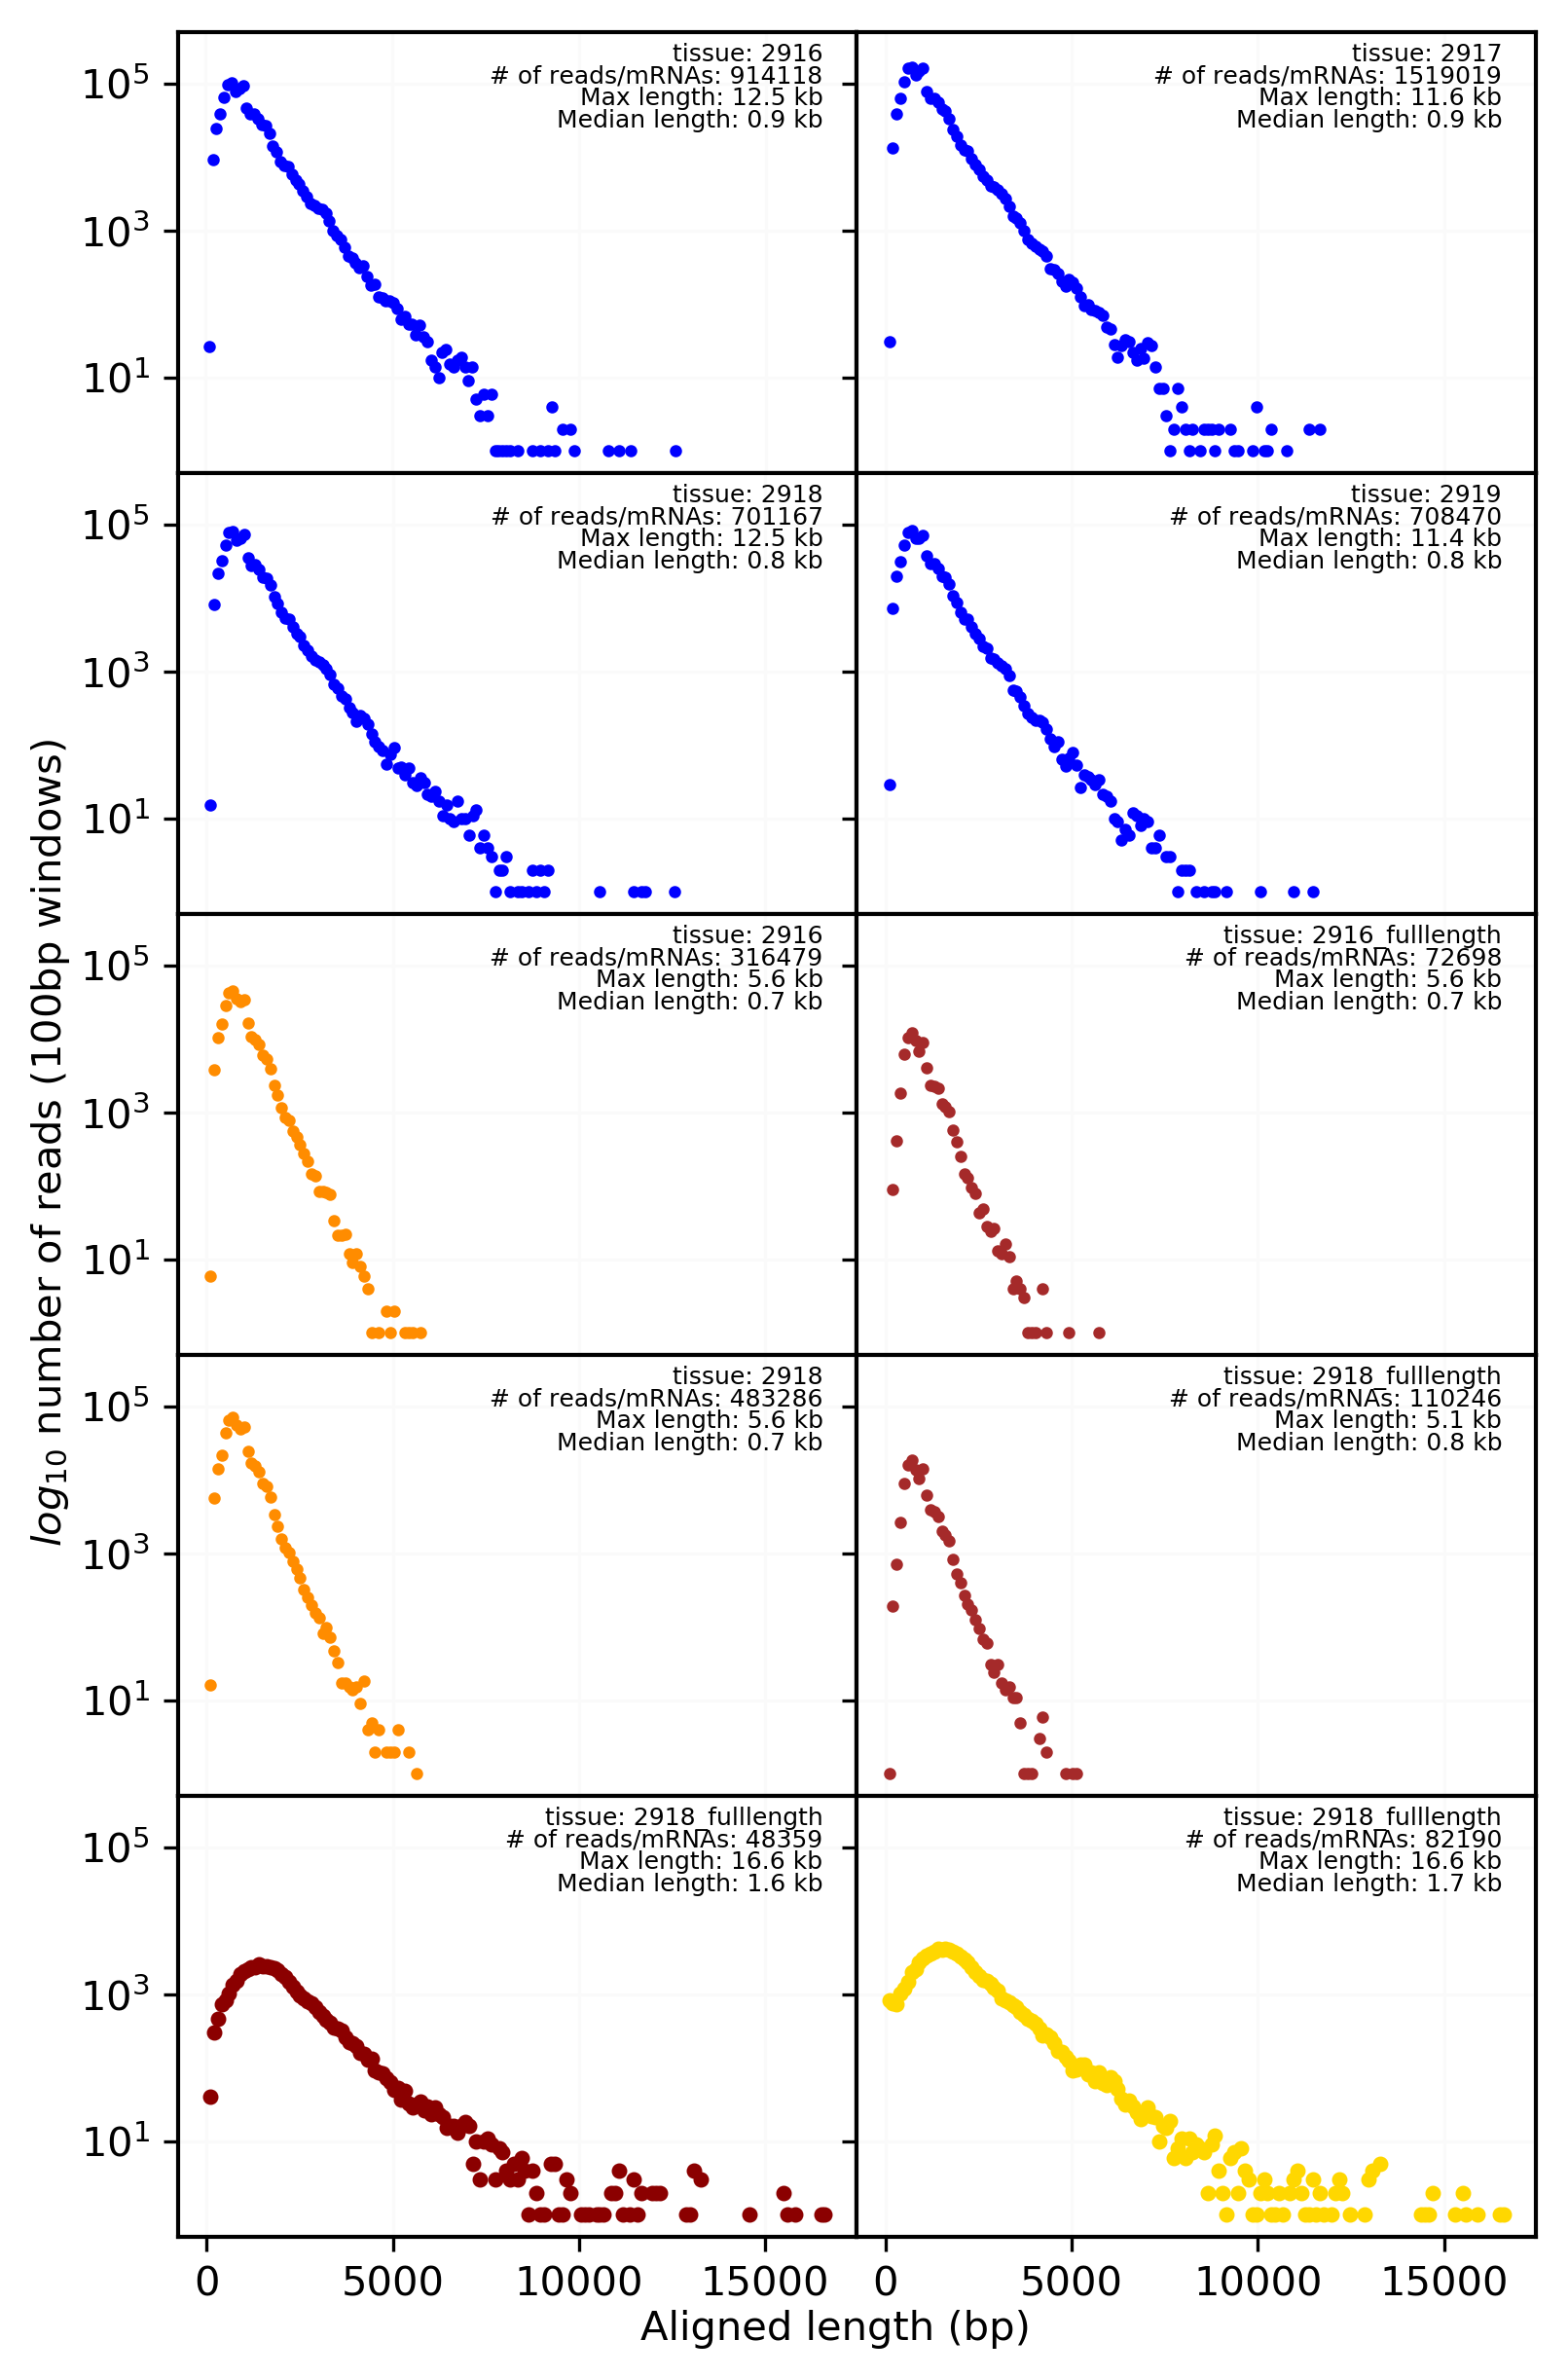

In [13]:
# Make plot
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['svg.fonttype'] = 'none'

def plotScatterHist(plot_index, data, bins, label, sharex, sharey, color=None, rows=5,
                    cols=2, s=8, fontsize=6, showxlabels=True):
    ax = plt.subplot(rows, cols, plot_index, sharex=sharex, sharey=sharey)
    rlhist = numpy.histogram(data, bins)
    if color is None:
        color='blue'
    plt.ylim(0.5,500000)
    if sharey is None:
        ax.set_yscale("log")
    else:
        plt.setp(ax.get_yticklabels(), visible=False)
    if not showxlabels:
        plt.setp(ax.get_xticklabels(), visible=False)
    ax.text(0.95, 0.95, plotlabel, ha='right', va='center',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(0.95, 0.9, "# of reads/mRNAs: {}".format(len(data)), ha='right',
            va='center', transform=ax.transAxes, fontsize=fontsize)
    ax.text(0.95, 0.85, "Max length: {:.1f} kb".format(data.max()/1E3), ha='right',
            va='center', transform=ax.transAxes, fontsize=fontsize)
    ax.text(0.95, 0.80, "Median length: {:.1f} kb".format(int(numpy.median(data))/1E3), ha='right',
            va='center', transform=ax.transAxes, fontsize=fontsize)
    plt.grid(color='0.98', linestyle='-', zorder=1)
    plt.minorticks_off()
    plt.scatter(rlhist[1][1:], rlhist[0], s=s, label=label, color=color, zorder=2)
    return(ax)

fig1 = plt.figure(figsize=(6,10), dpi=300)
subplot_index=1
bins=numpy.linspace(1,16600,16600/100)
axes=[]
for dataset in read_lengths.keys():
    if subplot_index == 1:
        sharey=None
        sharex=None
    elif subplot_index == 2:
        sharey=axes[0]
        sharex=None
    elif subplot_index in [3,5,7]:
        sharey=None
        sharex=axes[subplot_index-2]
    else:
        sharey=axes[subplot_index-2]
        sharex=axes[subplot_index-2]
    plotlabel = "tissue: {}".format(re.sub("run.+_tissue","",dataset))
    
    color='blue'
    if subplot_index == 5 or subplot_index == 7:
        color='darkorange'
    if subplot_index == 6 or subplot_index == 8:
        color='brown'
    ax = plotScatterHist(subplot_index, read_lengths[dataset][1], bins, plotlabel,
                         sharex, sharey, s=4, color=color, showxlabels=False)
    plt.subplots_adjust(hspace=.0, wspace=.0)
    axes.append(ax)
    subplot_index+=1

# add araport plot
ax = plotScatterHist(subplot_index, araport_lens, bins, "Araport",
                     axes[subplot_index-2], None, color='darkred')
axes.append(ax)
subplot_index+=1

# add atRTD
ax = plotScatterHist(subplot_index, atRTD_lens, bins, "atRTD",
                     axes[subplot_index-2], axes[subplot_index-2], color='gold')
axes.append(ax)

xlabel = fig1.text(0.5, 0.09, "Aligned length (bp)", ha='center')
ylabel = fig1.text(0.04, 0.5, r"$log_{10}$ number of reads (100bp windows)",
                   va='center', rotation='vertical')

plt.savefig("/cluster/gjb_lab/nschurch/new_cluster_workspace/ONTdrstools/Paper figures/Figure1_vert_fl.svg",
           format='svg', transparent=True, bbox_inches='tight', frameon=False)

/cluster/gjb_lab/nschurch/cluster_installs/miniconda2/envs/python3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


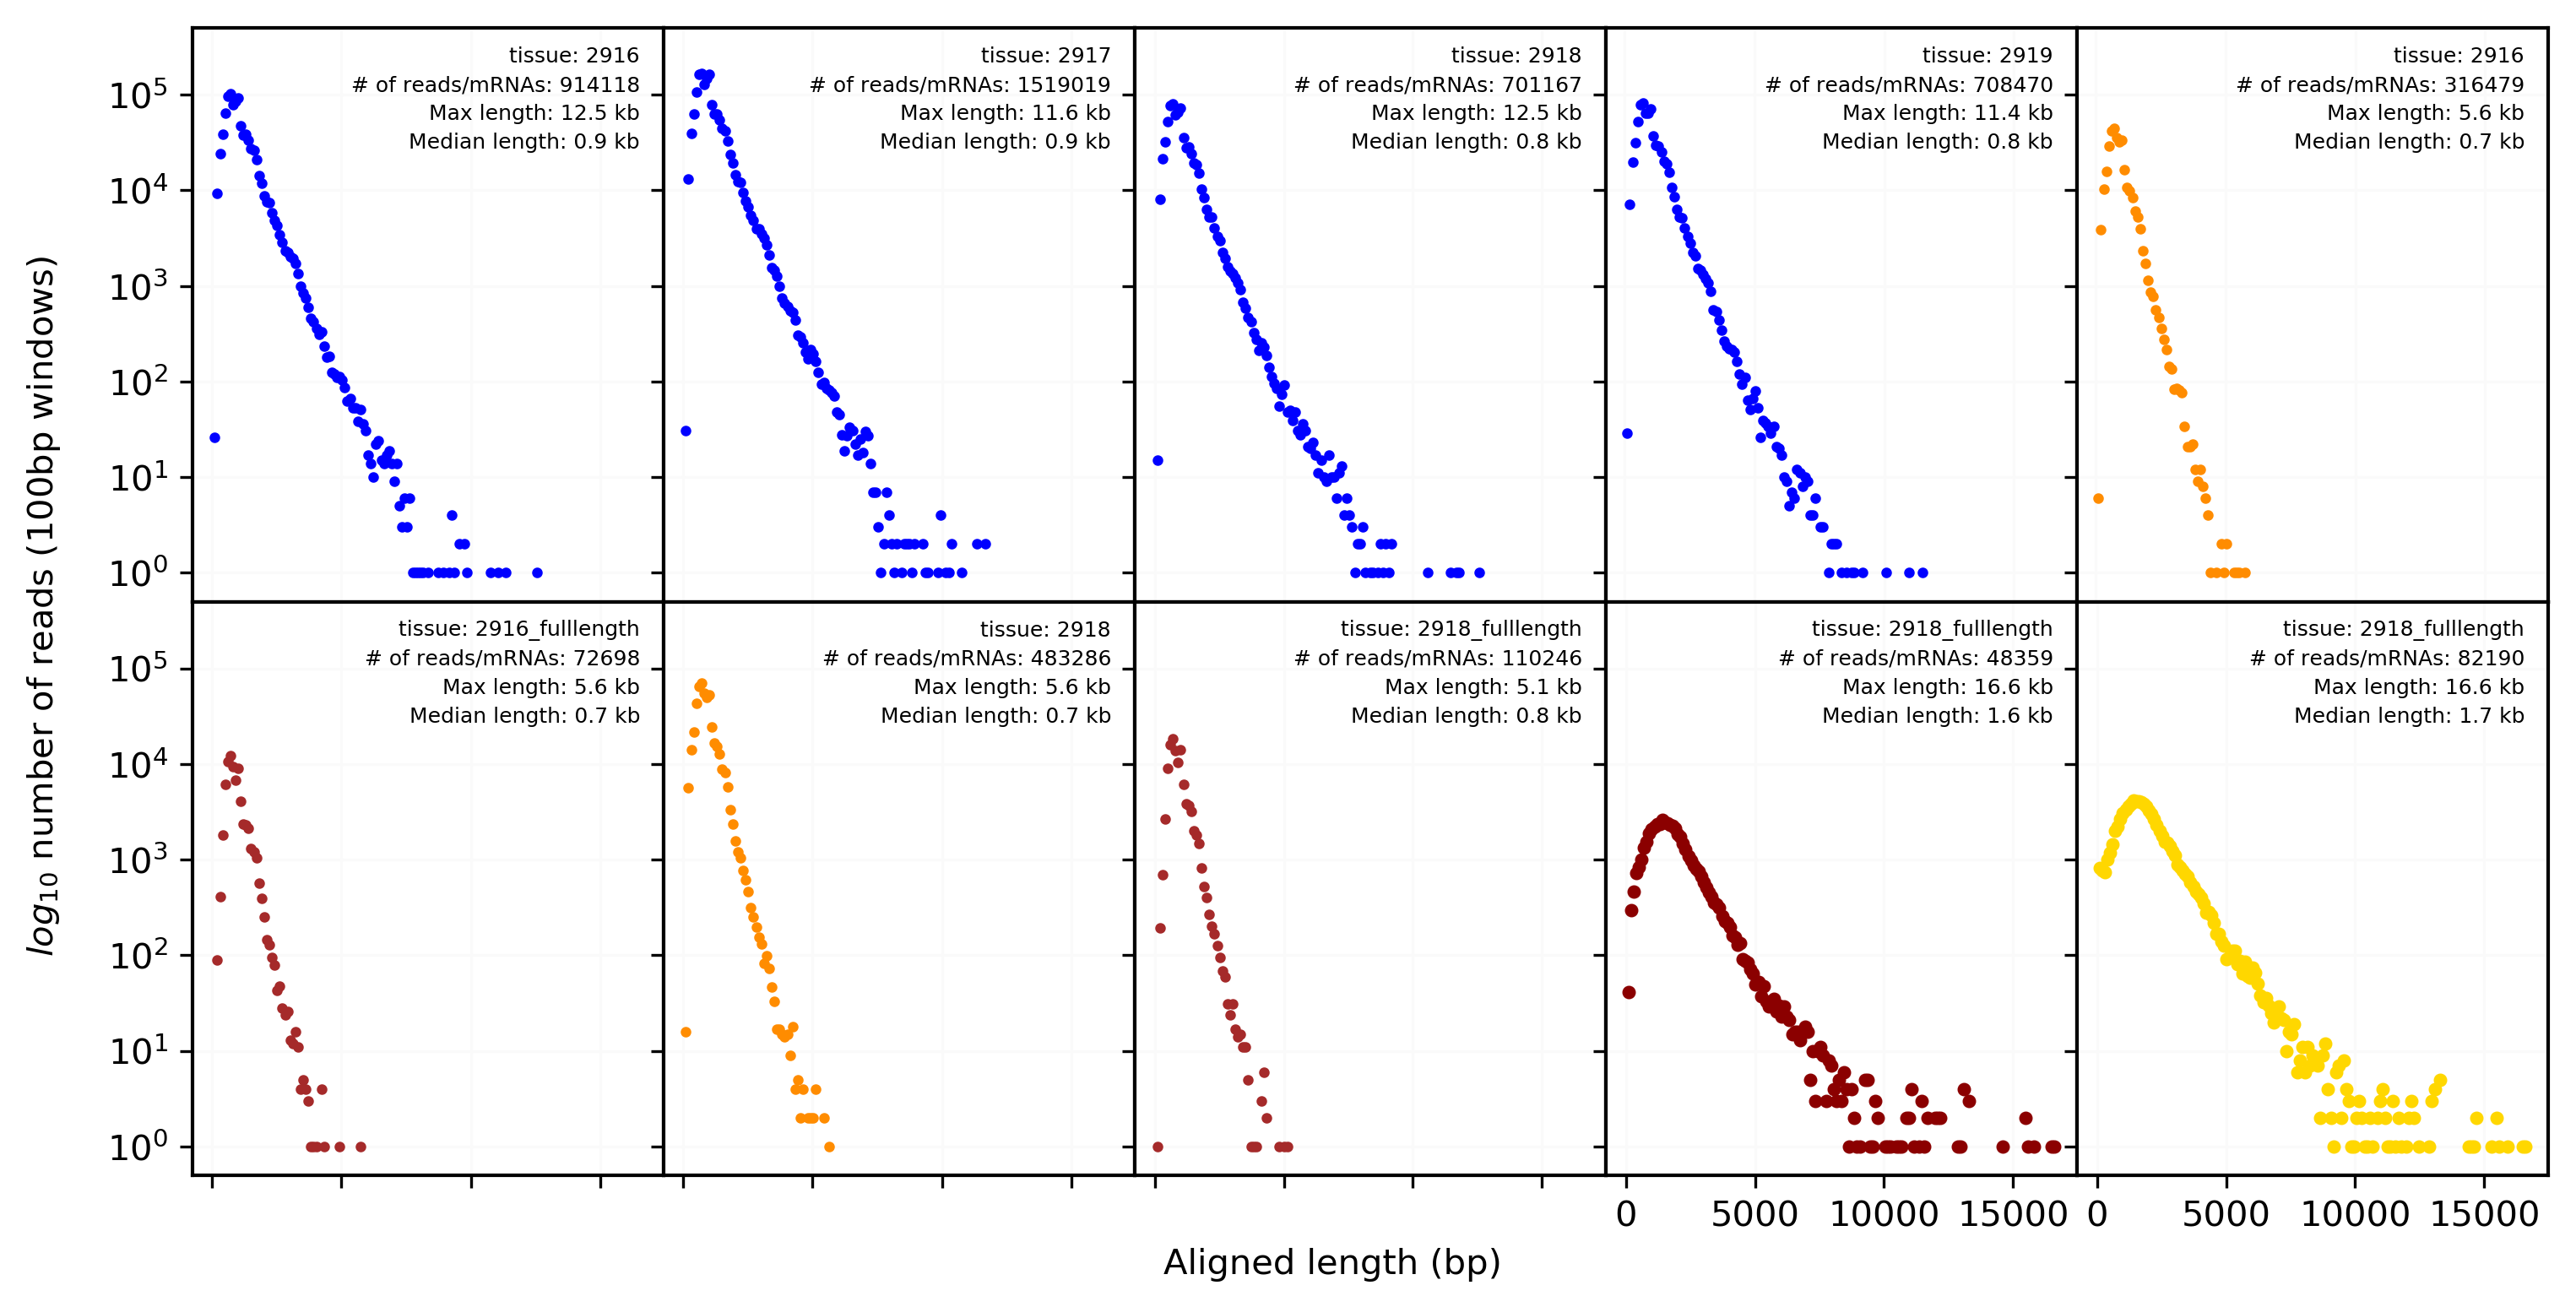

In [15]:
fig1 = plt.figure(figsize=(12,6), dpi=300)
subplot_index=1
bins=numpy.linspace(1,16600,16600/100)
axes=[]
showxlabels=False
for dataset in read_lengths.keys():
    if subplot_index == 1:
        sharey=None
        sharex=None
    elif subplot_index in [2,3,4,5]:
        sharey=axes[0]
        sharex=None
    elif subplot_index == 6:
        sharey=None
        sharex=axes[subplot_index-6]
    else:
        sharey=axes[5]
        sharex=axes[subplot_index-6]
    plotlabel = "tissue: {}".format(re.sub("run.+_tissue","",dataset))
    
    color='blue'
    if subplot_index == 5 or subplot_index == 7:
        color='darkorange'
    if subplot_index == 6 or subplot_index == 8:
        color='brown'
    ax = plotScatterHist(subplot_index, read_lengths[dataset][1], bins, plotlabel,
                         sharex, sharey, s=4, color=color, showxlabels=showxlabels, rows=2,
                         cols=5)
    plt.subplots_adjust(hspace=.0, wspace=.0)
    axes.append(ax)
    subplot_index+=1

# add araport plot
ax = plotScatterHist(subplot_index, araport_lens, bins, "Araport",
                     axes[subplot_index-2], axes[4], color='darkred',
                     rows=2, cols=5)
axes.append(ax)
subplot_index+=1

# add atRTD
ax = plotScatterHist(subplot_index, atRTD_lens, bins, "atRTD",
                     axes[subplot_index-2], axes[4], color='gold',
                     rows=2, cols=5)
axes.append(ax)

xlabel = fig1.text(0.5, 0.06, "Aligned length (bp)", ha='center')
ylabel = fig1.text(0.07, 0.5, r"$log_{10}$ number of reads (100bp windows)",
                   va='center', rotation='vertical')

plt.savefig("/cluster/gjb_lab/nschurch/new_cluster_workspace/ONTdrstools/Paper figures/Figure1_horiz_fl.svg",
           format='svg', transparent=True, bbox_inches='tight', frameon=False)

In [19]:
for dataset in read_lengths.keys():
    print("{} maximum read length: {}".format(dataset, read_lengths[dataset][1].max()))
    print("{} mean read length: {:.2f}".format(dataset, read_lengths[dataset][1].mean()))
    print("{} median read length: {}\n".format(dataset, numpy.median(read_lengths[dataset][1])))

run008_tissue2916 maximum read length: 12540
run008_tissue2916 mean read length: 992.04
run008_tissue2916 median read length: 864.0

run010_tissue2917 maximum read length: 11640
run010_tissue2917 mean read length: 991.20
run010_tissue2917 median read length: 867.0

run013_tissue2918 maximum read length: 12481
run013_tissue2918 mean read length: 962.20
run013_tissue2918 median read length: 839.0

run014_tissue2919 maximum read length: 11421
run014_tissue2919 mean read length: 962.93
run014_tissue2919 median read length: 840.0

run011_tissue2916 maximum read length: 5645
run011_tissue2916 mean read length: 814.21
run011_tissue2916 median read length: 733.0

run011_tissue2916_fulllength maximum read length: 5645
run011_tissue2916_fulllength mean read length: 840.91
run011_tissue2916_fulllength median read length: 747.0

run016_tissue2918 maximum read length: 5566
run016_tissue2918 mean read length: 813.64
run016_tissue2918 median read length: 734.0

run016_tissue2918_fulllength maximum re